<a href="https://colab.research.google.com/github/eireford/ConwayLifeTensorFlow/blob/master/LTF_heuristic_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Life on TensorFlow
##Heuristic Life algorithm performance

  Using heuristic algorythm (not machine learning) in this environment (Colab) TensorFlow shows significant performance improvements on GPU over SciPy.

Results 1000 runs
 - TensorFlow on GPU: 2.5 s
 - SciPy on GPU: 176.3 s
 - TensorFlow on CPU: 298.1 s
 - SciPy on CPU: 173.2 s

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
import numpy as np
import scipy.signal
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
    '\n\nThis error most likely means that this notebook is not '
    'configured to use a GPU.  Change this in Notebook Settings via the '
    'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print(f"Found GPU at: {device_name}")

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [2]:
default_grid_shape = [2048,2048]

def random_uniform_grid(shape=default_grid_shape):
  return tf.round(tf.random.uniform(shape=shape,dtype=tf.float32))

X_COMMON = random_uniform_grid()
alive_total = tf.reduce_sum(X_COMMON)
alive_ratio = alive_total/(X_COMMON.shape[0]*X_COMMON.shape[1])
print(f"living cells: {int(alive_total):,.0f} {alive_ratio:.3%}")
#expect approx. 50% alive

living cells: 2,095,793 49.968%


TensorFlow implementation 

In [0]:
# a density map is kernal
def convolve_for_density_map_TensorFlow(X):
  livable_filter_tf = tf.constant([[[[1]],[[1]],[[1]]],
                                   [[[1]],[[10]],[[1]]],
                                   [[[1]],[[1]],[[1]]]],dtype=tf.float32)
  #print(livable_filter_tf.shape)
  #v = tf.reshape(livable_filter_tf, [3,3,1,1])
  #print(v.shape)
  X_reshaped = tf.reshape(X,[1,X.shape[0],X.shape[1],1])
  denisty_map = tf.reshape(tf.nn.conv2d(X_reshaped,livable_filter_tf,[1,1,1,1],"SAME"),X.shape)
  return denisty_map 

def will_be_alive_TensorFlow_simple(density_map):
  is_three = tf.equal(density_map,3.0)
  is_twelve = tf.equal(density_map,12.0)
  is_thirteen = tf.equal(density_map,13.0)
  any_true = is_three | is_twelve | is_thirteen
  return tf.cast(any_true,dtype=tf.float32)

def run_tensorflow_simple(running_state,steps): 
  for i in range(steps):
    density_map = convolve_for_density_map_TensorFlow(running_state)
    running_state = will_be_alive_TensorFlow_simple(density_map)
  return running_state

SciPy implementation

In [0]:
def convolve_for_density_map_SciPy(X):
  livable_filter_sp = [[1,1,1],[1,10,1],[1,1,1]]
  denisty_map = scipy.signal.convolve2d(X,livable_filter_sp,"same")
  return denisty_map

def will_be_alive_NumPy(X):
  return ((X == 3) | (X == 12) | (X == 13))

def run_SciPy(running_state,steps): 
  for i in range(steps):
    density_map = convolve_for_density_map_SciPy(running_state)
    running_state = will_be_alive_NumPy(density_map)
  return running_state

TensorFlow alternative 1

In [0]:
def convolve_for_neighbor_sum(X):
  neighbor_sum_kernal = tf.constant([[1,1,1],[1,0,1],[1,1,1]],dtype=tf.float32)
  kernal = tf.reshape(neighbor_sum_kernal, [3,3,1,1])
  X_reshaped = tf.reshape(X,[1,X.shape[0],X.shape[1],1])
  density_map = tf.reshape(tf.nn.conv2d(X_reshaped,kernal,[1,1,1,1],"SAME"),X.shape)
  return density_map

def sustain(neighbor_sum):
  return tf.cast(((-1.0 * (neighbor_sum - 2.5)**2 + 1.0) > 0),tf.float32)

def enliven(neighbor_sum):
  return tf.cast(((-1.0 * (neighbor_sum - 3.0)**2 + 0.25) > 0),tf.float32)

def will_be_alive_TensorFlow_alt1(X,neighbor_sum):
  return tf.cast(tf.where(X==1,sustain(neighbor_sum),enliven(neighbor_sum)),dtype=tf.float32)

def run_TensorFlow_alt1(running_state,steps): 
  for i in range(steps):
    neighbor_sum = convolve_for_neighbor_sum(running_state)
    running_state = will_be_alive_TensorFlow_alt1(running_state,neighbor_sum)
  return running_state

TensorFlow alternative 1a

In [0]:
def sustain_alt1a(neighbor_sum):
  return tf.cast(((-1.0 * (neighbor_sum - 12.5)**2 + 1.0) > 0),tf.float32)

def will_be_alive_TensorFlow_alt1a(X):
  return tf.cast(tf.where(X==1,sustain_alt1a(X),enliven(X)),dtype=tf.float32)

def run_TensorFlow_alt1a(running_state,steps):
  for i in range(steps):
    density_map = convolve_for_density_map_TensorFlow(running_state)
    running_state = will_be_alive_TensorFlow_alt1a(density_map)
  return running_state

TensorFlow alternative 2

In [0]:
def will_be_alive_TensorFlow_alt2(X):
  zeros = tf.zeros(X.shape,dtype=tf.float32)
  ones = tf.ones(X.shape,dtype=tf.float32)
  result = tf.where(((X == 3) | (X == 12) | (X == 13)),ones,zeros)
  return result

def run_TensorFlow_alt2(running_state,steps): 
  for i in range(steps):
    density_map = convolve_for_density_map_TensorFlow(running_state)
    running_state = will_be_alive_TensorFlow_alt2(density_map)
  return running_state

Hardware specific executions

In [0]:
def run_TensorFlow_cpu(steps):
  with tf.device('/cpu:0'):
    return run_tensorflow_simple(X_COMMON,steps)

def run_TensorFlow_cpu2(steps):
  with tf.device('/cpu:0'):
    return run_TensorFlow_alt1(X_COMMON,steps)

def run_TensorFlow_cpu3(steps):
  with tf.device('/cpu:0'):
    return run_TensorFlow_alt2(X_COMMON,steps)

def run_TensorFlow_gpu(steps):
  with tf.device('/gpu:0'):
    return run_tensorflow_simple(X_COMMON,steps)

def run_TensorFlow_alt1_gpu(steps):
  with tf.device('/gpu:0'):
    return run_TensorFlow_alt1(X_COMMON,steps)

def run_TensorFlow_alt1a_gpu(steps):
  with tf.device('/gpu:0'):
    return run_TensorFlow_alt1a(X_COMMON,steps)

def run_TensorFlow_alt2_gpu(steps):
  with tf.device('/gpu:0'):
    return run_TensorFlow_alt2(X_COMMON,steps)

def run_SciPy_cpu(steps):
  with tf.device('/cpu:0'):
    return run_SciPy(X_COMMON,steps)

def run_SciPy_gpu(steps):
  with tf.device('/gpu:0'):
    return run_SciPy(X_COMMON,steps)

Quick Test

In [9]:
#quick run
%time Y_SciPy_gpu = run_SciPy_gpu(9)
%time Y_SciPy_cpu = run_SciPy_cpu(9)
%time Y_TensorFlow_gpu = run_TensorFlow_gpu(9)
%time Y_TensorFlow_cpu = run_TensorFlow_cpu(9)
%time Y_TensorFlow_alt1_gpu = run_TensorFlow_alt1_gpu(9)
%time Y_TensorFlow_alt1a_gpu = run_TensorFlow_alt1a_gpu(9)
%time Y_TensorFlow_alt2_gpu = run_TensorFlow_alt2_gpu(9)
;

CPU times: user 1.59 s, sys: 35.1 ms, total: 1.62 s
Wall time: 1.62 s
CPU times: user 1.6 s, sys: 9.81 ms, total: 1.61 s
Wall time: 1.61 s
CPU times: user 929 ms, sys: 391 ms, total: 1.32 s
Wall time: 1.4 s
CPU times: user 5.4 s, sys: 49.6 ms, total: 5.45 s
Wall time: 2.8 s
CPU times: user 10.1 ms, sys: 4.01 ms, total: 14.1 ms
Wall time: 28.5 ms
CPU times: user 9.91 ms, sys: 1.06 ms, total: 11 ms
Wall time: 27.5 ms
CPU times: user 9.62 ms, sys: 332 µs, total: 9.95 ms
Wall time: 23 ms


''

In [0]:
# gpu = cpu
assert(np.array_equal(Y_TensorFlow_gpu,Y_TensorFlow_cpu))
assert(np.array_equal(Y_SciPy_gpu,Y_SciPy_cpu))
# Scipy = Tensorflow
assert(np.array_equal(Y_TensorFlow_gpu,Y_SciPy_cpu))
# Alternative = TensorFlow
assert(np.array_equal(Y_TensorFlow_gpu,Y_TensorFlow_alt1_gpu))
assert(np.array_equal(Y_TensorFlow_gpu,Y_TensorFlow_alt2_gpu))

Performance Tests

In [11]:
print('TensorFlow on GPU:',end=' ')
time_TensorFlow_gpu = timeit.timeit('run_TensorFlow_gpu(1000)', number=1, setup="from __main__ import run_TensorFlow_gpu")
print(f"{time_TensorFlow_gpu:,.1f} s")

print('SciPy on GPU:',end=' ')
time_run_SciPy_gpu = timeit.timeit('run_SciPy_gpu(1000)', number=1, setup="from __main__ import run_SciPy_gpu")
print(f"{time_run_SciPy_gpu:,.1f} s") 

print('TensorFlow on CPU:',end=' ')
time_TensorFlow_cpu = timeit.timeit('run_TensorFlow_cpu(1000)', number=1, setup="from __main__ import run_TensorFlow_cpu")
print(f"{time_TensorFlow_cpu:,.1f} s")

print('SciPy on CPU:',end=' ')
time_run_SciPy_gpu = timeit.timeit('run_SciPy_cpu(1000)', number=1, setup="from __main__ import run_SciPy_cpu")
print(f"{time_run_SciPy_gpu:,.1f} s") 

TensorFlow on GPU: 2.5 s
SciPy on GPU: 176.3 s
TensorFlow on CPU: 298.1 s
SciPy on CPU: 173.2 s


In [12]:
#Compare TensorFlow alternatives
print('TensorFlow on GPU:',end=' ')
time_TensorFlow_gpu = timeit.timeit('run_TensorFlow_gpu(1000)', number=10, setup="from __main__ import run_TensorFlow_gpu")
print(f"{time_TensorFlow_gpu:,.1f} s")

print('TensorFlow alt1 on GPU:',end=' ')
time_TensorFlow_alt1_gpu = timeit.timeit('run_TensorFlow_alt1_gpu(1000)', number=10, setup="from __main__ import run_TensorFlow_alt1_gpu")
print(f"{time_TensorFlow_alt1_gpu:,.1f} s")

print('TensorFlow alt2 on GPU:',end=' ')
time_TensorFlow_alt2_gpu = timeit.timeit('run_TensorFlow_alt2_gpu(1000)', number=10, setup="from __main__ import run_TensorFlow_alt2_gpu")
print(f"{time_TensorFlow_alt2_gpu:,.1f} s") 

TensorFlow on GPU: 24.4 s
TensorFlow alt1 on GPU: 31.7 s
TensorFlow alt2 on GPU: 25.5 s


In [13]:
#Compare TensorFlow alternatives
print('TensorFlow on GPU:',end=' ')
time_TensorFlow_gpu = timeit.timeit('run_TensorFlow_gpu(20000)', number=1, setup="from __main__ import run_TensorFlow_gpu")
print(f"{time_TensorFlow_gpu:,.1f} s") 
print('TensorFlow alt1 on GPU:',end=' ')
time_TensorFlow_alt1_gpu = timeit.timeit('run_TensorFlow_alt1_gpu(20000)', number=1, setup="from __main__ import run_TensorFlow_alt1_gpu")
print(f"{time_TensorFlow_alt1_gpu:,.1f} s")
print('TensorFlow alt1a on GPU:',end=' ')
time_TensorFlow_alt1a_gpu = timeit.timeit('run_TensorFlow_alt1a_gpu(20000)', number=1, setup="from __main__ import run_TensorFlow_alt1a_gpu")
print(f"{time_TensorFlow_alt1a_gpu:,.1f} s")
print('TensorFlow alt2 on GPU:',end=' ')
time_TensorFlow_alt2_gpu = timeit.timeit('run_TensorFlow_alt2_gpu(20000)', number=1, setup="from __main__ import run_TensorFlow_alt2_gpu")
print(f"{time_TensorFlow_alt2_gpu:,.1f} s") 

TensorFlow on GPU: 48.9 s
TensorFlow alt1 on GPU: 63.5 s
TensorFlow alt1a on GPU: 62.3 s
TensorFlow alt2 on GPU: 50.9 s


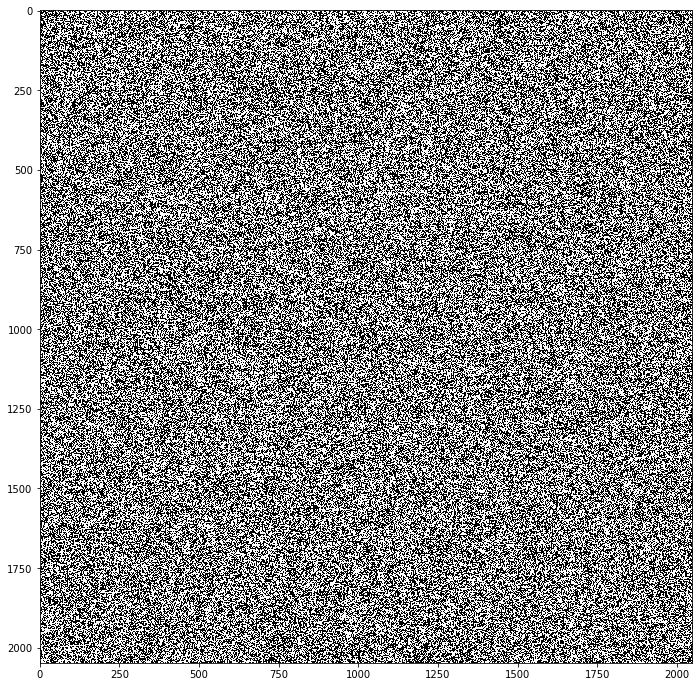

In [14]:
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(X_COMMON,cmap='Greys',origin='upper',interpolation='nearest')

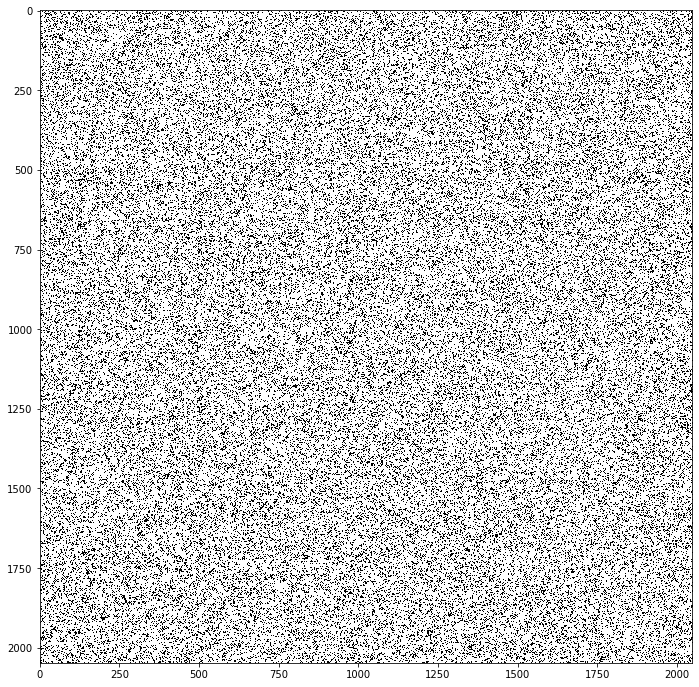

In [15]:
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(Y_TensorFlow_gpu,cmap='Greys',origin='upper',interpolation='nearest')

Tests For debugging

In [0]:
def test_grid0():
  return tf.constant([[0., 0., 1., 1., 1., 1., 1.],
                      [0., 0., 1., 1., 1., 1., 0.],
                      [1., 0., 1., 1., 1., 0., 1.],
                      [0., 0., 0., 0., 1., 0., 0.],
                      [0., 0., 1., 0., 1., 1., 0.],
                      [0., 0., 1., 1., 1., 1., 1.],
                      [1., 0., 0., 1., 0., 0., 0.]])

In [0]:
def test_grid1():
  return tf.constant([[0., 0., 1., 0., 0., 0., 1.],
                      [0., 0., 0., 0., 0., 0., 0.],
                      [0., 1., 1., 0., 0., 0., 0.],
                      [0., 1., 1., 0., 0., 0., 0.],
                      [0., 0., 1., 0., 0., 0., 1.],
                      [0., 1., 1., 0., 0., 0., 1.],
                      [0., 0., 1., 1., 0., 1., 0.]])

In [0]:
t1 = test_grid0()
t2 = test_grid1()

r2 = run_TensorFlow_alt2(t1,1)
assert(np.array_equal(t2,r2))

In [19]:
print(r2)

tf.Tensor(
[[0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0.]], shape=(7, 7), dtype=float32)


In [20]:
print(t2)

tf.Tensor(
[[0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0.]], shape=(7, 7), dtype=float32)
